# OLS - regression

Here we will create our baseline linear model. It will not contain time-dependent exogenous variables. What is more we will not focus on econometrics - BLUE assumptions!

### Dependencies loading

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import pickle
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 150)

### Data loading

In [113]:
df = pd.read_csv("../data/train_fe.csv", index_col=0)

In [114]:
fr = pd.read_excel("../data/feature_ranking.xlsx",index_col=0)

### Feature engineering for OLS regression model

We can omit this step, because all crucial transformations like: mathematical transformations, feature creation, dummification have been already applied.

### Final feature selection for OLS regression model

#### Feature ranking

We will start with prepared in previous notebook "feature ranking". Taking into account OLS estimator properties the most important for us is output from Elastic Net (EN_coef). Let's treat this variables as our benchmark input into OLS regression model.  

In [115]:
fr.sort_values("mi_score", ascending=False).head()

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
etr_y_past,1.007860,1.304040e-84,1,0.520405,NaN,1
etr_y_ma,0.825573,2.473770e-125,1,0.526827,NaN,1
txt,0.633965,5.246456e-13,1,0.368732,1.466269e-05,1
diff,0.628929,2.257712e-02,1,-0.291716,NaN,1
ni,0.616573,1.747230e-09,1,0.263458,-3.442000e-07,2


In [116]:
benchmark_input = fr["EN_coef"].dropna().index.tolist()

We treat year as a cont. variable!

In [117]:
benchmark_input

['rok',
 'ta',
 'txt',
 'pi',
 'xrd',
 'ni',
 'ppent',
 'intant',
 'dlc',
 'dltt',
 'capex',
 'revenue',
 'cce',
 'adv',
 'WB_GDPpc',
 'sektor_materials',
 'sektor_utilities',
 'dltt_cat_(39.38, 327.85]',
 'dltt_cat_(327.85, 876.617]',
 'dltt_cat_(876.617, inf]']

In [118]:
benchmark_input.remove("dltt")

Let's check this variables in case of high collinearity! We see that we don't deal with this problem.

In [119]:
corr = df[benchmark_input].corr("kendall")
foo = pd.DataFrame(corr.abs().unstack().sort_values(ascending=False))
foo = foo[foo[0]!=1]
foo = foo[foo.duplicated()==False]
foo.head(10)

,,0
ni,pi,0.833199
revenue,ta,0.782031
pi,txt,0.761797
cce,ta,0.746758
dlc,ta,0.721881
revenue,cce,0.680492
capex,ta,0.664255
ni,txt,0.662137
revenue,intant,0.634050
ta,pi,0.633319


#### Recursive Feature Elimination 

As an econometrician I know that the best procedure in case of feature selection for OLS is general to specific approach, where we use Wald Test. But right now let's do ML - so RFE procedure seems to be good enough to create "robust" estimator. We will use RFE with CV. This CV is not the best one cause we will apply our own CV in the next chapter, but right now let's use CV implemented in scikit-learn.

In [120]:
print(df.columns.tolist())

['Ticker', 'Nazwa2', 'rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'etr', 'diff', 'roa', 'lev', 'intan', 'rd', 'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4', 'gielda_5', 'ta_log', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(-34.811, 0.488]', 'txt_cat_(0.488, 24.415]', 'txt_cat_(24.415, 25.05]', 'txt_cat_(25.05, 308.55]', 'txt_cat_(308.55, 327.531]', 'txt_cat_(327.531, inf]', 'pi_cat_(-8975.0, -1.523]', 'pi_cat_(-1.523, 157.119]', 'pi_cat_(157.119, 465.9]', 'pi_cat_(465.9, 7875.5]', 'pi_cat_(7875.5, 8108.5]', 'pi_c

We will provide all possible variables and then (after RFE) we will investigate possible collinearity!!!

In the first attempt let's create set of variables without discretization.

In [121]:
rfe_candidates = ['rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'diff', 'roa', 'lev', 'intan', 'rd', 'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 
                  'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 
                  'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4',
                  'gielda_5', 'ta_log', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(-34.811, 0.488]', 'txt_cat_(0.488, 24.415]', 'txt_cat_(24.415, 25.05]', 'txt_cat_(25.05, 308.55]', 'txt_cat_(308.55, 327.531]', 'txt_cat_(327.531, inf]',
                  'pi_cat_(-8975.0, -1.523]', 'pi_cat_(-1.523, 157.119]', 'pi_cat_(157.119, 465.9]', 'pi_cat_(465.9, 7875.5]', 'pi_cat_(7875.5, 8108.5]', 'pi_cat_(8108.5, inf]', 'str_cat_(0.0875, 0.192]', 'str_cat_(0.192, 0.28]', 
                  'str_cat_(0.28, inf]', 'xrd_exists', 'ni_profit', 'ni_profit_20000', 'ppent_sqrt', 'intant_sqrt', 'dlc_cat_(42.262, 176.129]', 'dlc_cat_(176.129, 200.9]', 'dlc_cat_(200.9, inf]', 'dltt_cat_(39.38, 327.85]', 
                  'dltt_cat_(327.85, 876.617]', 'dltt_cat_(876.617, inf]', 'capex_cat_(7.447, 79.55]', 'capex_cat_(79.55, 5451.0]', 'capex_cat_(5451.0, inf]', 'revenue_cat_(0.174, 1248.817]', 'revenue_cat_(1248.817, 4233.587]',
                  'revenue_cat_(4233.587, inf]', 'cce_cat_(5.619, 63.321]', 'cce_cat_(63.321, inf]', 'adv_cat_(0.3, 874.5]', 'adv_cat_(874.5, inf]', 'diff_positive', 'roa_clip', 'lev_sqrt', 'intan_pow2', 'rd_sqrt', 'ppe_clip', 
                  'cash_holdings_sqrt', 'adv_expenditure_positive', 'diff_dta', 'cfc_dta']

In [122]:
rfe_candidates_without_disc = [i for i in rfe_candidates if "]" not in i]

In [123]:
print(rfe_candidates_without_disc)

['rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'diff', 'roa', 'lev', 'intan', 'rd', 'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4', 'gielda_5', 'ta_log', 'xrd_exists', 'ni_profit', 'ni_profit_20000', 'ppent_sqrt', 'intant_sqrt', 'diff_positive', 'roa_clip', 'lev_sqrt', 'intan_pow2', 'rd_sqrt', 'ppe_clip', 'cash_holdings_sqrt', 'adv_expenditure_positive', 'diff_dta', 'cfc_dta']


In [124]:
fr.loc[["ta","ta_log"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
ta,0.581221,1.464884e-03,1,0.26734,-1.404307e-07,49
ta_log,0.565568,1.007512e-29,1,0.26734,NaN,43


In [125]:
rfe_candidates_without_disc.remove("ta_log")

In [126]:
fr.loc[["ppent","ppent_sqrt"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
ppent,0.539112,2.882495e-05,1,0.122606,-0.000001,27
ppent_sqrt,0.522217,2.322729e-09,1,0.122606,NaN,28


In [127]:
rfe_candidates_without_disc.remove("ppent_sqrt")

In [128]:
fr.loc[["intant","intant_sqrt"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
intant,0.601354,3.058156e-13,1,0.296425,3.013313e-07,38
intant_sqrt,0.589650,8.457669e-25,1,0.296425,NaN,39


In [129]:
rfe_candidates_without_disc.remove("intant_sqrt")

In [130]:
fr.loc[["roa","roa_clip"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
roa,0.571836,0.000029,1,0.051264,NaN,25
roa_clip,0.572279,0.000032,1,0.051264,NaN,18


In [131]:
rfe_candidates_without_disc.remove("roa")

In [132]:
fr.loc[["lev","lev_sqrt"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
lev,0.507001,0.074493,1,-0.037398,NaN,34
lev_sqrt,0.496781,0.264156,0,-0.037398,NaN,37


In [133]:
rfe_candidates_without_disc.remove("lev")

In [134]:
fr.loc[["intan","intan_pow2"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
intan,0.543882,2.274383e-07,1,0.191233,NaN,56
intan_pow2,0.528494,4.133756e-03,1,0.191233,NaN,59


In [135]:
rfe_candidates_without_disc.remove("intan")

In [136]:
fr.loc[["rd","rd_sqrt"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
rd,0.085713,3.804198e-08,1,0.263277,NaN,47
rd_sqrt,0.095526,7.632780e-18,1,0.263277,NaN,46


In [137]:
rfe_candidates_without_disc.remove("rd_sqrt")

In [138]:
fr.loc[["ppe","ppe_clip"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
ppe,0.518393,9.410492e-13,1,-0.162275,NaN,35
ppe_clip,0.521418,1.210225e-12,1,-0.162275,NaN,31


In [139]:
rfe_candidates_without_disc.remove("ppe")

In [140]:
fr.loc[["cash_holdings","cash_holdings_sqrt"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
cash_holdings,0.525249,0.200452,0,0.015851,NaN,52
cash_holdings_sqrt,0.527331,0.638415,0,0.015851,NaN,50


In [141]:
rfe_candidates_without_disc.remove("cash_holdings_sqrt")

In [142]:
fr.loc[["diff","diff_dta","cfc","cfc_dta"]]

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
diff,0.628929,2.257712e-02,1,-0.291716,NaN,1
diff_dta,0.064801,8.259023e-03,1,-0.049721,NaN,10
cfc,0.110702,9.686699e-47,1,0.313568,NaN,21
cfc_dta,0.052578,4.748841e-20,1,0.206484,NaN,70


In [143]:
print(rfe_candidates_without_disc)

['rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'diff', 'rd', 'sale', 'cash_holdings', 'adv_expenditure', 'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4', 'gielda_5', 'xrd_exists', 'ni_profit', 'ni_profit_20000', 'diff_positive', 'roa_clip', 'lev_sqrt', 'intan_pow2', 'ppe_clip', 'adv_expenditure_positive', 'diff_dta', 'cfc_dta']


In [144]:
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=5, min_features_to_select=10)
selector = selector.fit(df.loc[:,rfe_candidates_without_disc].values, df.loc[:,"etr"].values.ravel())
df.loc[:,rfe_candidates_without_disc].iloc[:,selector.support_].columns.tolist()

['str',
 'sale',
 'cash_holdings',
 'adv_expenditure',
 'cfc',
 'y_v2x_polyarchy',
 'y_e_p_polity',
 'rr_per_country',
 'rr_per_sector',
 'gielda_2',
 'gielda_4',
 'gielda_5',
 'ni_profit_20000',
 'diff_positive',
 'lev_sqrt',
 'diff_dta']

In [145]:
rfe_candidates_without_disc = df.loc[:,rfe_candidates_without_disc].iloc[:,selector.support_].columns.tolist()

In [146]:
rfe_candidates = ['rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'diff', 'roa', 'lev', 'intan', 'rd', 'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 
                  'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 
                  'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4',
                  'gielda_5', 'ta_log', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(-34.811, 0.488]', 'txt_cat_(0.488, 24.415]', 'txt_cat_(24.415, 25.05]', 'txt_cat_(25.05, 308.55]', 'txt_cat_(308.55, 327.531]', 'txt_cat_(327.531, inf]',
                  'pi_cat_(-8975.0, -1.523]', 'pi_cat_(-1.523, 157.119]', 'pi_cat_(157.119, 465.9]', 'pi_cat_(465.9, 7875.5]', 'pi_cat_(7875.5, 8108.5]', 'pi_cat_(8108.5, inf]', 'str_cat_(0.0875, 0.192]', 'str_cat_(0.192, 0.28]', 
                  'str_cat_(0.28, inf]', 'xrd_exists', 'ni_profit', 'ni_profit_20000', 'ppent_sqrt', 'intant_sqrt', 'dlc_cat_(42.262, 176.129]', 'dlc_cat_(176.129, 200.9]', 'dlc_cat_(200.9, inf]', 'dltt_cat_(39.38, 327.85]', 
                  'dltt_cat_(327.85, 876.617]', 'dltt_cat_(876.617, inf]', 'capex_cat_(7.447, 79.55]', 'capex_cat_(79.55, 5451.0]', 'capex_cat_(5451.0, inf]', 'revenue_cat_(0.174, 1248.817]', 'revenue_cat_(1248.817, 4233.587]',
                  'revenue_cat_(4233.587, inf]', 'cce_cat_(5.619, 63.321]', 'cce_cat_(63.321, inf]', 'adv_cat_(0.3, 874.5]', 'adv_cat_(874.5, inf]', 'diff_positive', 'roa_clip', 'lev_sqrt', 'intan_pow2', 'rd_sqrt', 'ppe_clip', 
                  'cash_holdings_sqrt', 'adv_expenditure_positive', 'diff_dta', 'cfc_dta']

In [147]:
rfe_candidates.remove("ta_log")
rfe_candidates.remove("ppent_sqrt")
rfe_candidates.remove("intant_sqrt")
rfe_candidates.remove("roa")
rfe_candidates.remove("lev")
rfe_candidates.remove("intan")
rfe_candidates.remove("rd_sqrt")
rfe_candidates.remove("ppe")
rfe_candidates.remove("cash_holdings_sqrt")

In [148]:
print(rfe_candidates)

['rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'diff', 'rd', 'sale', 'cash_holdings', 'adv_expenditure', 'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4', 'gielda_5', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(-34.811, 0.488]', 'txt_cat_(0.488, 24.415]', 'txt_cat_(24.415, 25.05]', 'txt_cat_(25.05, 308.55]', 'txt_cat_(308.55, 327.531]', 'txt_cat_(327.531, inf]', 'pi_cat_(-8975.0, -1.523]', 'pi_cat_(-1.523, 157.119]', 'pi_cat_(157.119, 465.9]', 'pi_cat_(465.9, 7875.5]', 'pi_cat_(7875.5, 8108.5]', 'pi_cat_(8108.5, inf]', 'str_cat_(0.0875, 0.192]', 'str_cat_(0.192, 0.28

In [149]:
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=5,min_features_to_select=9,)
selector = selector.fit(df.loc[:,rfe_candidates].values, df.loc[:,"etr"].values.ravel())
print(df.loc[:,rfe_candidates].iloc[:,selector.support_].columns.tolist())
rfe_candidates = df.loc[:,rfe_candidates].iloc[:,selector.support_].columns.tolist()

['str', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(308.55, 327.531]', 'pi_cat_(-8975.0, -1.523]', 'pi_cat_(-1.523, 157.119]', 'pi_cat_(157.119, 465.9]', 'pi_cat_(465.9, 7875.5]', 'pi_cat_(7875.5, 8108.5]', 'pi_cat_(8108.5, inf]']


Now we have 3 sets of candidates!

Let's investigate permutation importance of such candidates!

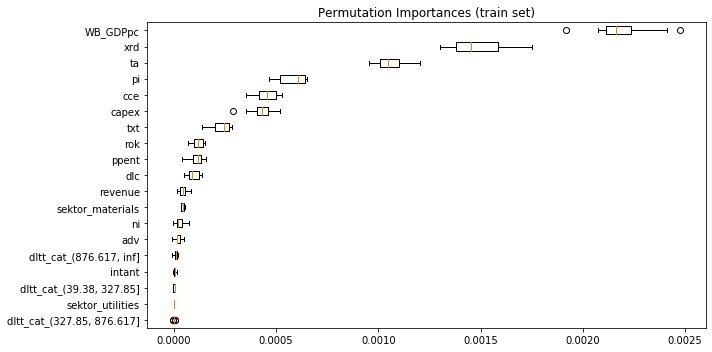

In [150]:
estimator = LinearRegression()
estimator.fit(df.loc[:,benchmark_input].values, df.loc[:,"etr"].values.ravel())
result = permutation_importance(estimator, df.loc[:,benchmark_input].values, df.loc[:,"etr"].values.ravel(), n_repeats=10, scoring='neg_mean_squared_error', random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=df.loc[:,benchmark_input].columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

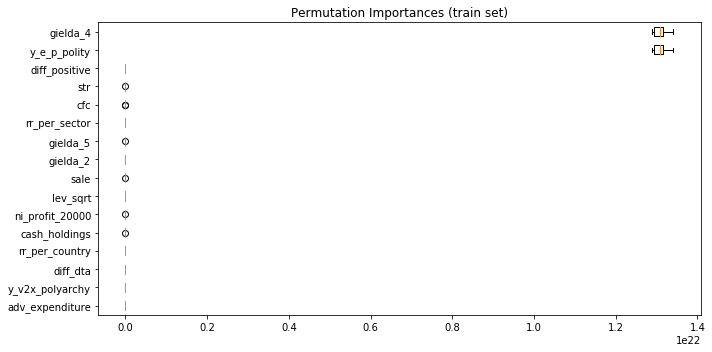

In [151]:
estimator = LinearRegression()
estimator.fit(df.loc[:,rfe_candidates_without_disc].values, df.loc[:,"etr"].values.ravel())
result = permutation_importance(estimator, df.loc[:,rfe_candidates_without_disc].values, df.loc[:,"etr"].values.ravel(), n_repeats=10, scoring='neg_mean_squared_error', random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=df.loc[:,rfe_candidates_without_disc].columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

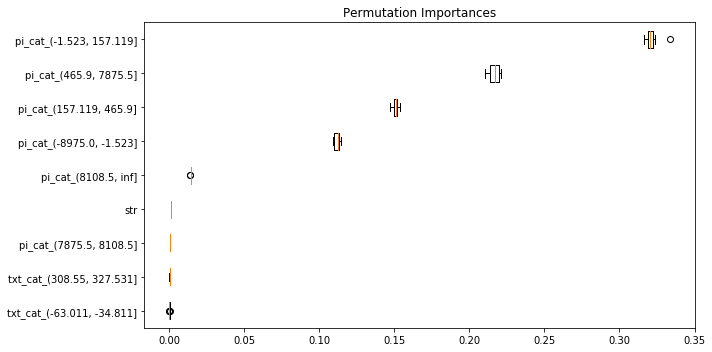

In [152]:
estimator = LinearRegression()
estimator.fit(df.loc[:,rfe_candidates].values, df.loc[:,"etr"].values.ravel())
result = permutation_importance(estimator, df.loc[:,rfe_candidates].values, df.loc[:,"etr"].values.ravel(), n_repeats=10, scoring='neg_mean_squared_error', random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=df.loc[:,rfe_candidates].columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

As we expect the most reasonable is set of variables from ElasticNet!

#### Permutation importance

Let's try something new for us - permutation importance for feature selection.

In [153]:
rfe_candidates = ['rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'diff', 'roa', 'lev', 'intan', 'rd', 'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 
                  'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 
                  'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4',
                  'gielda_5', 'ta_log', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(-34.811, 0.488]', 'txt_cat_(0.488, 24.415]', 'txt_cat_(24.415, 25.05]', 'txt_cat_(25.05, 308.55]', 'txt_cat_(308.55, 327.531]', 'txt_cat_(327.531, inf]',
                  'pi_cat_(-8975.0, -1.523]', 'pi_cat_(-1.523, 157.119]', 'pi_cat_(157.119, 465.9]', 'pi_cat_(465.9, 7875.5]', 'pi_cat_(7875.5, 8108.5]', 'pi_cat_(8108.5, inf]', 'str_cat_(0.0875, 0.192]', 'str_cat_(0.192, 0.28]', 
                  'str_cat_(0.28, inf]', 'xrd_exists', 'ni_profit', 'ni_profit_20000', 'ppent_sqrt', 'intant_sqrt', 'dlc_cat_(42.262, 176.129]', 'dlc_cat_(176.129, 200.9]', 'dlc_cat_(200.9, inf]', 'dltt_cat_(39.38, 327.85]', 
                  'dltt_cat_(327.85, 876.617]', 'dltt_cat_(876.617, inf]', 'capex_cat_(7.447, 79.55]', 'capex_cat_(79.55, 5451.0]', 'capex_cat_(5451.0, inf]', 'revenue_cat_(0.174, 1248.817]', 'revenue_cat_(1248.817, 4233.587]',
                  'revenue_cat_(4233.587, inf]', 'cce_cat_(5.619, 63.321]', 'cce_cat_(63.321, inf]', 'adv_cat_(0.3, 874.5]', 'adv_cat_(874.5, inf]', 'diff_positive', 'roa_clip', 'lev_sqrt', 'intan_pow2', 'rd_sqrt', 'ppe_clip', 
                  'cash_holdings_sqrt', 'adv_expenditure_positive', 'diff_dta', 'cfc_dta']

In [154]:
estimator = LinearRegression()
estimator.fit(df.loc[:,rfe_candidates].values, df.loc[:,"etr"].values.ravel())
result = permutation_importance(estimator, df.loc[:,rfe_candidates].values, df.loc[:,"etr"].values.ravel(), n_repeats=10, scoring='neg_mean_squared_error', random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

In [155]:
sorted_idx = sorted_idx[-20:]

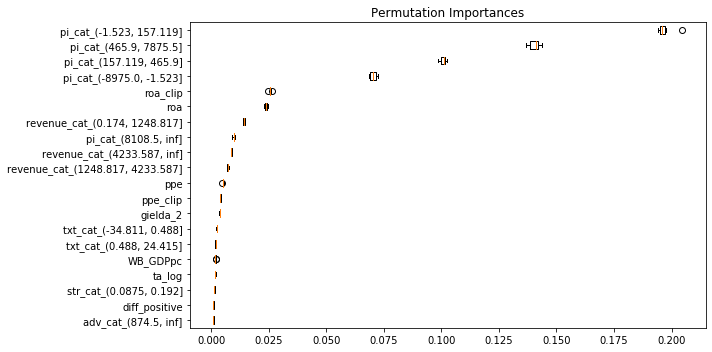

In [156]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=df.loc[:,rfe_candidates].columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

In [157]:
pi_var = df.loc[:,rfe_candidates].columns[sorted_idx].tolist()
pi_var.remove("roa")
pi_var.remove("ppe")

In [158]:
estimator = LinearRegression()
estimator.fit(df.loc[:,pi_var].values, df.loc[:,"etr"].values.ravel())
result = permutation_importance(estimator, df.loc[:,pi_var].values, df.loc[:,"etr"].values.ravel(), n_repeats=10, scoring='neg_mean_squared_error', random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

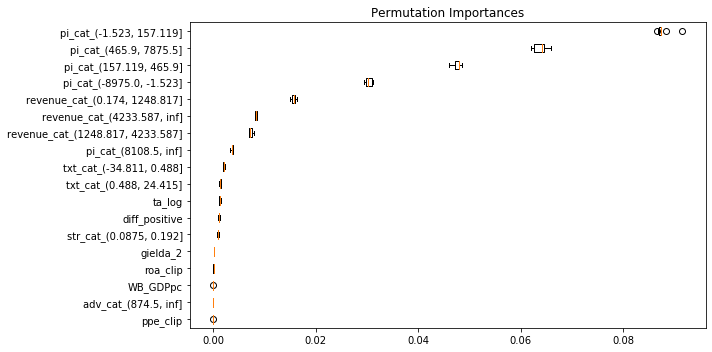

In [159]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=df.loc[:,pi_var].columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

In [160]:
pi_var_prim = pi_var[-9:]

#### Forward elimination

Finally let's try backward feature selection!

In [161]:
candidates = ['rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'diff', 'roa', 'lev', 'intan', 'rd', 'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 
                  'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer discretionary', 
                  'sektor_consumer staples', 'sektor_energy', 'sektor_health care', 'sektor_industrials', 'sektor_materials', 'sektor_real estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4',
                  'gielda_5', 'ta_log', 'txt_cat_(-63.011, -34.811]', 'txt_cat_(-34.811, 0.488]', 'txt_cat_(0.488, 24.415]', 'txt_cat_(24.415, 25.05]', 'txt_cat_(25.05, 308.55]', 'txt_cat_(308.55, 327.531]', 'txt_cat_(327.531, inf]',
                  'pi_cat_(-8975.0, -1.523]', 'pi_cat_(-1.523, 157.119]', 'pi_cat_(157.119, 465.9]', 'pi_cat_(465.9, 7875.5]', 'pi_cat_(7875.5, 8108.5]', 'pi_cat_(8108.5, inf]', 'str_cat_(0.0875, 0.192]', 'str_cat_(0.192, 0.28]', 
                  'str_cat_(0.28, inf]', 'xrd_exists', 'ni_profit', 'ni_profit_20000', 'ppent_sqrt', 'intant_sqrt', 'dlc_cat_(42.262, 176.129]', 'dlc_cat_(176.129, 200.9]', 'dlc_cat_(200.9, inf]', 'dltt_cat_(39.38, 327.85]', 
                  'dltt_cat_(327.85, 876.617]', 'dltt_cat_(876.617, inf]', 'capex_cat_(7.447, 79.55]', 'capex_cat_(79.55, 5451.0]', 'capex_cat_(5451.0, inf]', 'revenue_cat_(0.174, 1248.817]', 'revenue_cat_(1248.817, 4233.587]',
                  'revenue_cat_(4233.587, inf]', 'cce_cat_(5.619, 63.321]', 'cce_cat_(63.321, inf]', 'adv_cat_(0.3, 874.5]', 'adv_cat_(874.5, inf]', 'diff_positive', 'roa_clip', 'lev_sqrt', 'intan_pow2', 'rd_sqrt', 'ppe_clip', 
                  'cash_holdings_sqrt', 'adv_expenditure_positive', 'diff_dta', 'cfc_dta']

In [162]:
model = LinearRegression()

In [163]:
sf = SFS(model, 
           k_features=(1,10), 
           forward=True, 
           floating=False, 
           verbose=0,
           scoring='neg_mean_squared_error',
           cv=5)

sffit = sf.fit(df.loc[:,candidates].values, df.loc[:,"etr"].values.ravel())

sf_features = df.loc[:,candidates].columns[list(sffit.k_feature_idx_)]

In [164]:
sf_features

Index(['sale', 'txt_cat_(-34.811, 0.488]', 'txt_cat_(0.488, 24.415]',
       'txt_cat_(308.55, 327.531]', 'pi_cat_(7875.5, 8108.5]',
       'str_cat_(0.0875, 0.192]', 'str_cat_(0.28, inf]',
       'dlc_cat_(176.129, 200.9]', 'capex_cat_(5451.0, inf]', 'diff_positive'],
      dtype='object')

### Models performance in a proper CV

We would like to fight against data leakage in our CV, so we will treat it like a panel problem with a rolling window. We now based on our experience that this kind of approach is crucial to fight against overfitting.

Sliding window:
 * T: 2005 - 2008; V: 2009
 * T: 2005 - 2009; V: 2010
 * T: 2005 - 2010; V: 2011
 * ...

In [165]:
df = df.sort_values(by="rok").reset_index(drop=True)

In [166]:
def proper_CV(x, y, model, display_res = False):
    train_score = list()
    valid_score = list()
    train_indexes = [0, 1452]
    valid_indexes = [1452, 1815]
    for i in range(0,6):
        train_x =  x[x.index.isin(range(train_indexes[0],train_indexes[1]))]
        train_y =  y[y.index.isin(range(train_indexes[0],train_indexes[1]))]
        valid_x =  x[x.index.isin(range(valid_indexes[0],valid_indexes[1]))]
        valid_y =  y[y.index.isin(range(valid_indexes[0],valid_indexes[1]))]

        model.fit(train_x.values, train_y.values.ravel())
        
        pred_y_train = model.predict(train_x.values)
        rmse = np.sqrt(mean_squared_error(train_y, pred_y_train))
        train_score.append(rmse)

        pred_y_val = model.predict(valid_x.values)
        rmse = np.sqrt(mean_squared_error(valid_y, pred_y_val))
        valid_score.append(rmse)
        
        train_indexes = [0, valid_indexes[1]]
        valid_indexes = [train_indexes[1], valid_indexes[1]+363]
    
    if display_res == True:
        view = pd.DataFrame([train_score, valid_score]).T.rename(columns = {0:"cv_train", 1:"cv_val"})
        display(view)
        return train_score, valid_score, view
    else:
        return train_score, valid_score

In [167]:
model = LinearRegression()
cv_output1 = proper_CV(df.loc[:,benchmark_input], df.loc[:,"etr"], model, display_res=True)

,cv_train,cv_val
0,0.152740,0.133980
1,0.148943,0.140114
2,0.147364,0.152003
3,0.147964,0.151252
4,0.148128,0.135353
5,0.146686,0.142455


In [168]:
estimator = LinearRegression()
cv_output2 = proper_CV(df.loc[:,rfe_candidates_without_disc], df.loc[:,"etr"], model, display_res=True)

,cv_train,cv_val
0,0.148365,0.131115
1,0.144976,0.134240
2,0.143128,0.147825
3,0.143760,0.145526
4,0.143936,0.131903
5,0.142611,0.138851


In [169]:
estimator = LinearRegression()
cv_output3 = proper_CV(df.loc[:,rfe_candidates], df.loc[:,"etr"], model, display_res=True)

,cv_train,cv_val
0,0.137473,0.156177
1,0.137276,0.133388
2,0.135747,0.146417
3,0.136633,0.147629
4,0.137060,0.174296
5,0.136293,0.134812


In [170]:
estimator = LinearRegression()
cv_output4 = proper_CV(df.loc[:,pi_var], df.loc[:,"etr"], model, display_res=True)

,cv_train,cv_val
0,0.145918,0.135789
1,0.143588,0.133894
2,0.141838,0.148464
3,0.142696,0.144123
4,0.142785,0.131333
5,0.141453,0.138599


In [171]:
estimator = LinearRegression()
cv_output5 = proper_CV(df.loc[:,pi_var_prim], df.loc[:,"etr"], model, display_res=True)

,cv_train,cv_val
0,0.153126,0.136002
1,0.149701,0.142231
2,0.148336,0.154069
3,0.149078,0.149230
4,0.149064,0.137927
5,0.147776,0.143449


In [172]:
estimator = LinearRegression()
cv_output6 = proper_CV(df.loc[:,sf_features], df.loc[:,"etr"], model, display_res=True)

,cv_train,cv_val
0,0.145656,0.131990
1,0.142899,0.127553
2,0.140355,0.148713
3,0.141532,0.141179
4,0.141423,0.129587
5,0.140049,0.138519


In [173]:
pd.DataFrame([cv_output1[2].mean().tolist(), 
cv_output2[2].mean().tolist(),
cv_output3[2].mean().tolist(),
cv_output4[2].mean().tolist(),
cv_output5[2].mean().tolist(),
cv_output6[2].mean().tolist()], columns=["train_mean", "test_mean"])

,train_mean,test_mean
0,0.148638,0.142526
1,0.144463,0.138243
2,0.136747,0.148787
3,0.143046,0.138700
4,0.149514,0.143818
5,0.141986,0.136257


In [174]:
pd.DataFrame([cv_output1[2].std().tolist(), 
cv_output2[2].std().tolist(),
cv_output3[2].std().tolist(),
cv_output4[2].std().tolist(),
cv_output5[2].std().tolist(),cv_output6[2].std().tolist()], columns=["train_std", "test_std"])

,train_std,test_std
0,0.002148,0.007698
1,0.002072,0.007103
2,0.000652,0.015131
3,0.001596,0.006490
4,0.001891,0.006824
5,0.002061,0.008037


4rd model seems to be the best based on our CV (we took int account mean and std score!!!).

In [176]:
print(pi_var)

['adv_cat_(874.5, inf]', 'diff_positive', 'str_cat_(0.0875, 0.192]', 'ta_log', 'WB_GDPpc', 'txt_cat_(0.488, 24.415]', 'txt_cat_(-34.811, 0.488]', 'gielda_2', 'ppe_clip', 'revenue_cat_(1248.817, 4233.587]', 'revenue_cat_(4233.587, inf]', 'pi_cat_(8108.5, inf]', 'revenue_cat_(0.174, 1248.817]', 'roa_clip', 'pi_cat_(-8975.0, -1.523]', 'pi_cat_(157.119, 465.9]', 'pi_cat_(465.9, 7875.5]', 'pi_cat_(-1.523, 157.119]']


### Fit final model and save it

In [109]:
model = LinearRegression()
model.fit(df.loc[:,pi_var].values, df.loc[:,"etr"].values.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [110]:
filename = 'final_models/ols.sav'

In [111]:
pickle.dump(model, open(filename, 'wb'))